In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_text.zip
/kaggle/input/msk-redefining-cancer-treatment/training_text.zip
/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z


In [2]:
import matplotlib.pyplot as plt
import re
import time
import warnings
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [3]:
!pip install patool

     |████████████████████████████████| 81kB 2.2MB/s 


In [4]:
!pip install pyunpack

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=010be948cfb05bd24cf5035a3ab5926ae49e2b9212d4684540f3bf4d911cd069
  Stored in directory: /tmp/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack


In [5]:
from pyunpack import Archive
Archive('/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z').extractall('/kaggle/working')

In [6]:
Archive('/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z').extractall('/kaggle/working')

In [7]:
df=pd.read_csv('/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip')
dftest=pd.read_csv('/kaggle/working/stage2_test_variants.csv')

In [8]:
df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
dftest.head()

,ID,Gene,Variation
0,1,CHEK2,H371Y
1,2,AXIN2,Truncating Mutations
2,3,WNT4,E216G
3,4,SUCLA2,G118R
4,5,BRAF,T599insTT


In [10]:
print('Train Number of data points:', df.shape[0])
print('Train Number of features:',df.shape[1])
print('Train Features:',df.columns.values)

print('Test Number of data points:', dftest.shape[0])
print('Test Number of features:',dftest.shape[1])
print('Test Features:',dftest.columns.values)

Train Number of data points: 3321
Train Number of features: 4
Train Features: ['ID' 'Gene' 'Variation' 'Class']
Test Number of data points: 986
Test Number of features: 3
Test Features: ['ID' 'Gene' 'Variation']


In [11]:
dftext=pd.read_csv('/kaggle/input/msk-redefining-cancer-treatment/training_text.zip', 
                   sep='\|\|', names=['ID', 'TEXT'], skiprows=1, engine='python')
dftesttext=pd.read_csv('/kaggle/working/stage2_test_text.csv', 
                   sep='\|\|', names=['ID', 'TEXT'], skiprows=1, engine='python')

In [12]:
dftext.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [13]:
print('Number of data points:', dftext.shape[0])

Number of data points: 3321


In [14]:
dftesttext.head()

,ID,TEXT
0,1,The incidence of breast cancer is increasing i...
1,2,An unselected series of 310 colorectal carcino...
2,3,Mycosis fungoides and Sézary syndrome are prim...
3,4,Regulated progression through the cell cycle ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [15]:
print('Test Number of data points:', dftesttext.shape[0])

Test Number of data points: 986


### Preprocessing of Text

In [16]:
# loading stopwords from nltk library

stop_words=set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column, cat):
    if type(total_text) is not int:
        s1=""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        for word in total_text.split():
            # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                s1 += word + " "
        if cat=='train':
            dftext[column][index] = s1
        elif cat=='test':
            dftesttext[column][index]=s1

In [17]:
#text processing stage.
start_time = time.clock()
for index, row in dftext.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT', 'train')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 54.781084 seconds


In [18]:
#text processing stage  -  test data
start_time = time.clock()
for index, row in dftesttext.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT', 'test')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 16.45398099999999 seconds


In [19]:
#merging both gene_variations and text data based on ID
result = pd.merge(df, dftext,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [21]:
result.loc[result['TEXT'].isnull(), 'TEXT']= result['Gene']+' '+result['Variation']

In [22]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [23]:
result['GV']=result['Gene']+' '+result['Variation']

In [24]:
result.head()

,ID,Gene,Variation,Class,TEXT,GV
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,FAM58A Truncating Mutations
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,CBL W802*
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,CBL Q249E
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,CBL N454D
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,CBL L399V


In [25]:
#merging both gene_variations and text data based on ID - Test data
resulttest = pd.merge(dftest, dftesttext,on='ID', how='left')
resulttest.head()

,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,incidence breast cancer increasing china recen...
1,2,AXIN2,Truncating Mutations,unselected series 310 colorectal carcinomas st...
2,3,WNT4,E216G,mycosis fungoides zary syndrome primary cutane...
3,4,SUCLA2,G118R,regulated progression cell cycle requires sequ...
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerging tumor entity...


In [26]:
resulttest[resulttest.isnull().any(axis=1)]

,ID,Gene,Variation,TEXT


In [27]:
resulttest.loc[resulttest['TEXT'].isnull(), 'TEXT']= resulttest['Gene']+' '+resulttest['Variation']

In [28]:
resulttest[resulttest.isnull().any(axis=1)]

,ID,Gene,Variation,TEXT


In [29]:
resulttest['GV']=resulttest['Gene']+' '+resulttest['Variation']

In [30]:
resulttest.head()

,ID,Gene,Variation,TEXT,GV
0,1,CHEK2,H371Y,incidence breast cancer increasing china recen...,CHEK2 H371Y
1,2,AXIN2,Truncating Mutations,unselected series 310 colorectal carcinomas st...,AXIN2 Truncating Mutations
2,3,WNT4,E216G,mycosis fungoides zary syndrome primary cutane...,WNT4 E216G
3,4,SUCLA2,G118R,regulated progression cell cycle requires sequ...,SUCLA2 G118R
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerging tumor entity...,BRAF T599insTT


### Splitting data into train and cross validation (70:30)

In [31]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')
# split the data into cv and train by maintaining same distribution of output
#varaible 'y_true' [stratify=y_true]
xtrain, xcv, ytrain, ycv = train_test_split(result, y_true, stratify=y_true, test_size=0.3)


In [32]:
print('Number of data points in train data:', xtrain.shape[0])
print('Number of data points in cross validation data:', xcv.shape[0])

Number of data points in train data: 2324
Number of data points in cross validation data: 997


In [33]:
## Distribution of classes

train_class_distribution = xtrain['Class'].value_counts().sort_index()
cv_class_distribution = xcv['Class'].value_counts().sort_index()

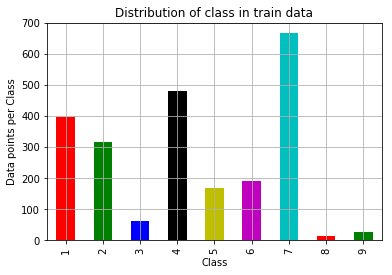

In [34]:
my_colors = ['r','g','b','k','y','m','c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of class in train data')
plt.grid()
plt.show()

In [35]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
      '(', np.round((train_class_distribution.values[i]/xtrain.shape[0]*100), 3), '%)')

Number of data points in class 7 : 667 ( 28.701 %)
Number of data points in class 4 : 480 ( 20.654 %)
Number of data points in class 1 : 398 ( 17.126 %)
Number of data points in class 2 : 316 ( 13.597 %)
Number of data points in class 6 : 193 ( 8.305 %)
Number of data points in class 5 : 169 ( 7.272 %)
Number of data points in class 3 : 62 ( 2.668 %)
Number of data points in class 9 : 26 ( 1.119 %)
Number of data points in class 8 : 13 ( 0.559 %)


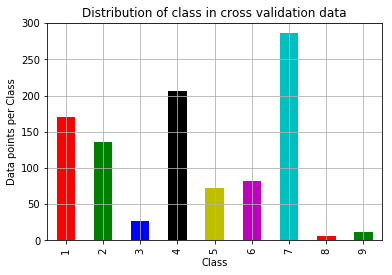

In [36]:
## cross-validation data

my_colors = ['r','g','b','k','y','m','c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of class in cross validation data')
plt.grid()
plt.show()

In [37]:
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i]/xcv.shape[0]*100), 3),'%)')

Number of data points in class 7 : 286 ( 28.686 %)
Number of data points in class 4 : 206 ( 20.662 %)
Number of data points in class 1 : 170 ( 17.051 %)
Number of data points in class 2 : 136 ( 13.641 %)
Number of data points in class 6 : 82 ( 8.225 %)
Number of data points in class 5 : 73 ( 7.322 %)
Number of data points in class 3 : 27 ( 2.708 %)
Number of data points in class 9 : 11 ( 1.103 %)
Number of data points in class 8 : 6 ( 0.602 %)


In [38]:
## to plot confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### TFIDF vectorization - One hot encoding

In [39]:
# TFIDF vectorization of variation feature
variation_vectorizer_tf = TfidfVectorizer()
train_variation_feature_tf=variation_vectorizer_tf.fit_transform(xtrain['Variation'])
cv_variation_feature_tf = variation_vectorizer_tf.transform(xcv['Variation'])

In [40]:
print('train variation feature TFIDF vectorized shape: ', train_variation_feature_tf.shape)
print('cv variation feature TFIDF vectorized shape: ', cv_variation_feature_tf.shape)

train variation feature TFIDF vectorized shape:  (2324, 2134)
cv variation feature TFIDF vectorized shape:  (997, 2134)


In [41]:
## Test 
test_variation_feature_tf=variation_vectorizer_tf.transform(resulttest['Variation'])
print('Test variation feature TFIDF vectorized shape:', test_variation_feature_tf.shape)

Test variation feature TFIDF vectorized shape: (986, 2134)


In [42]:
## TFIDF vectorization of Gene feature
gene_tf_vectorizer=TfidfVectorizer()
train_gene_feature_tf=gene_tf_vectorizer.fit_transform(xtrain['Gene'])
cv_gene_feature_tf=gene_tf_vectorizer.transform(xcv['Gene'])

In [43]:
print("Shape of train gene feature when tfidf vectorized : ", train_gene_feature_tf.shape)
print("Shape of cv gene feature when tfidf vectorized : ", cv_gene_feature_tf.shape)

Shape of train gene feature when tfidf vectorized :  (2324, 242)
Shape of cv gene feature when tfidf vectorized :  (997, 242)


In [44]:
# Test
test_gene_feature_tf=gene_tf_vectorizer.transform(resulttest['Gene'])
print("Shape of Test gene feature when tfidf vectorized : ", test_gene_feature_tf.shape)

Shape of Test gene feature when tfidf vectorized :  (986, 242)


In [45]:
# building a TFIDFVectorizer for TEXT with all the words that occurred minimum 3 times 
#in train data,
# and max features 6000 and taking 1gram to 5gram

text_vectorizer_tf=TfidfVectorizer(min_df=3, ngram_range=(1,5), max_features=100000)
train_text_feature_tf=text_vectorizer_tf.fit_transform(xtrain['TEXT'])
train_text_features=text_vectorizer_tf.get_feature_names()
print('total number of unique words in train data: ', len(train_text_features))
train_text_fea_counts_tf=train_text_feature_tf.sum(axis=0).A1
text_fea_dict_tf=dict(zip(list(train_text_features), train_text_fea_counts_tf))
cv_text_feature_tf=text_vectorizer_tf.transform(xcv['TEXT'])

#print(train_text_fea_counts_tf)

total number of unique words in train data:  100000


In [46]:
print(train_text_feature_tf.shape)
print(cv_text_feature_tf.shape)

(2324, 100000)
(997, 100000)


In [47]:
# Test
test_text_feature_tf=text_vectorizer_tf.transform(resulttest['TEXT'])
print(test_text_feature_tf.shape)

(986, 100000)


### Stacking the three types of TFIDF features

In [48]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_tf = hstack((train_gene_feature_tf,train_variation_feature_tf))
cv_gene_var_tf = hstack((cv_gene_feature_tf,cv_variation_feature_tf))

train_x_tf = hstack((train_gene_var_tf, train_text_feature_tf)).tocsr()
train_y = np.array(list(xtrain['Class']))

cv_x_tf = hstack((cv_gene_var_tf, cv_text_feature_tf)).tocsr()
cv_y = np.array(list(xcv['Class']))

In [49]:
print("TFIDF features :")
print("(number of data points * number of features) in train data = ", train_x_tf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tf.shape)

TFIDF features :
(number of data points * number of features) in train data =  (2324, 102376)
(number of data points * number of features) in cross validation data = (997, 102376)


In [50]:
## Test
test_gene_var_tf=hstack((test_gene_feature_tf, test_variation_feature_tf))
test_x_tf=hstack((test_gene_var_tf, test_text_feature_tf)).tocsr()
print('Test shape:', test_x_tf.shape)

Test shape: (986, 102376)


### Apply Logistic Regression with CountVectorizer including both unigrams and bigrams

for alpha = 1e-06
Log Loss : 1.1502172391688765
for alpha = 1e-05
Log Loss : 1.0025396953056531
for alpha = 0.0001
Log Loss : 0.9499584253996298
for alpha = 0.001
Log Loss : 1.0087524696027985
for alpha = 0.01
Log Loss : 1.1639368572471056
for alpha = 0.1
Log Loss : 1.3649181665112031
for alpha = 1
Log Loss : 1.4407496765182481
for alpha = 10
Log Loss : 1.452533858994557
for alpha = 100
Log Loss : 1.4539570769277614


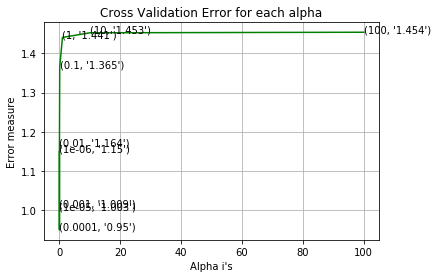

For values of best alpha =  0.0001 The train log loss is: 0.41546976844297673
For values of best alpha =  0.0001 The cross validation log loss is: 0.9499584253996298


In [51]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tf, train_y)

predict_y = sig_clf.predict_proba(train_x_tf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(ytrain, predict_y,  eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(ycv, predict_y,  eps=1e-15))


In [52]:
res = sig_clf.predict_proba(test_x_tf)

In [53]:
res

array([[0.22105649, 0.0652219 , 0.01890814, ..., 0.05263239, 0.0061801 ,
        0.0058829 ],
       [0.22729033, 0.12969382, 0.02143166, ..., 0.24406752, 0.00771046,
        0.00672713],
       [0.10264641, 0.10478853, 0.0118793 , ..., 0.53148159, 0.00809504,
        0.00248176],
       ...,
       [0.01112518, 0.53067921, 0.00592169, ..., 0.35789282, 0.00338783,
        0.00113641],
       [0.19426823, 0.11965524, 0.02396826, ..., 0.25557269, 0.00878046,
        0.01203557],
       [0.15839623, 0.3216582 , 0.01400397, ..., 0.17259606, 0.00703749,
        0.0059776 ]])

In [54]:
ids=np.arange(1, len(res)+1)

In [55]:
line1='class1 class2 class3 class4 class5 class6 class7 class8 class9'
s1=line1.split()
print(s1)

['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']


In [56]:
resdf=pd.DataFrame(res, columns=s1)

In [57]:
resdf.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0.221056,0.065222,0.018908,0.459464,0.044714,0.125940,0.052632,0.006180,0.005883
1,0.227290,0.129694,0.021432,0.244690,0.053047,0.065342,0.244068,0.007710,0.006727
2,0.102646,0.104789,0.011879,0.163045,0.033447,0.042136,0.531482,0.008095,0.002482
3,0.083849,0.141358,0.016289,0.151787,0.033969,0.029488,0.529711,0.006741,0.006809
4,0.012327,0.240786,0.009838,0.020539,0.034077,0.015508,0.661824,0.003720,0.001381


In [58]:
resdf.insert(0,'ID',ids,True)

In [59]:
resdf.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.221056,0.065222,0.018908,0.459464,0.044714,0.125940,0.052632,0.006180,0.005883
1,2,0.227290,0.129694,0.021432,0.244690,0.053047,0.065342,0.244068,0.007710,0.006727
2,3,0.102646,0.104789,0.011879,0.163045,0.033447,0.042136,0.531482,0.008095,0.002482
3,4,0.083849,0.141358,0.016289,0.151787,0.033969,0.029488,0.529711,0.006741,0.006809
4,5,0.012327,0.240786,0.009838,0.020539,0.034077,0.015508,0.661824,0.003720,0.001381


In [60]:
filename='cancer_treat_logistic.csv'
resdf.to_csv(filename, index=False)
print('Saved file ',filename)

Saved file  cancer_treat_logistic.csv
